In [16]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from xgboost import XGBClassifier
import optuna

In [17]:
df = pd.read_csv('fake_job_postings.csv')
df.head()
sample_row = df.loc[0].to_dict()
sample_row

{'job_id': 1,
 'title': 'Marketing Intern',
 'location': 'US, NY, New York',
 'department': 'Marketing',
 'salary_range': nan,
 'company_profile': "We're Food52, and we've created a groundbreaking and award-winning cooking site. We support, connect, and celebrate home cooks, and give them everything they need in one place.We have a top editorial, business, and engineering team. We're focused on using technology to find new and better ways to connect people around their specific food interests, and to offer them superb, highly curated information about food and cooking. We attract the most talented home cooks and contributors in the country; we also publish well-known professionals like Mario Batali, Gwyneth Paltrow, and Danny Meyer. And we have partnerships with Whole Foods Market and Random House.Food52 has been named the best food website by the James Beard Foundation and IACP, and has been featured in the New York Times, NPR, Pando Daily, TechCrunch, and on the Today Show.We're loca

In [18]:
df.dtypes
# df.select_dtypes('object').nunique()
# df.isnull().any()

job_id                  int64
title                  object
location               object
department             object
salary_range           object
company_profile        object
description            object
requirements           object
benefits               object
telecommuting           int64
has_company_logo        int64
has_questions           int64
employment_type        object
required_experience    object
required_education     object
industry               object
function               object
fraudulent              int64
dtype: object

# EDA

In [19]:
# take the top 10 departments only
department_list = list(df.department.value_counts().sort_values(ascending=False)[:10].keys())
# department_list = list(df.department.value_counts()[df.department.value_counts() > 100][10].keys())

df.department = df.department.apply(lambda x: x if x in department_list else 'other')
df.department.value_counts

<bound method IndexOpsMixin.value_counts of 0          Marketing
1              other
2              other
3              Sales
4              other
            ...     
17875          Sales
17876          other
17877          other
17878          other
17879    Engineering
Name: department, Length: 17880, dtype: object>

In [20]:
df.select_dtypes('object').nunique()

title                  11231
location                3105
department                11
salary_range             874
company_profile         1709
description            14801
requirements           11967
benefits                6204
employment_type            5
required_experience        7
required_education        13
industry                 131
function                  37
dtype: int64

<Axes: xlabel='department', ylabel='max_salary'>

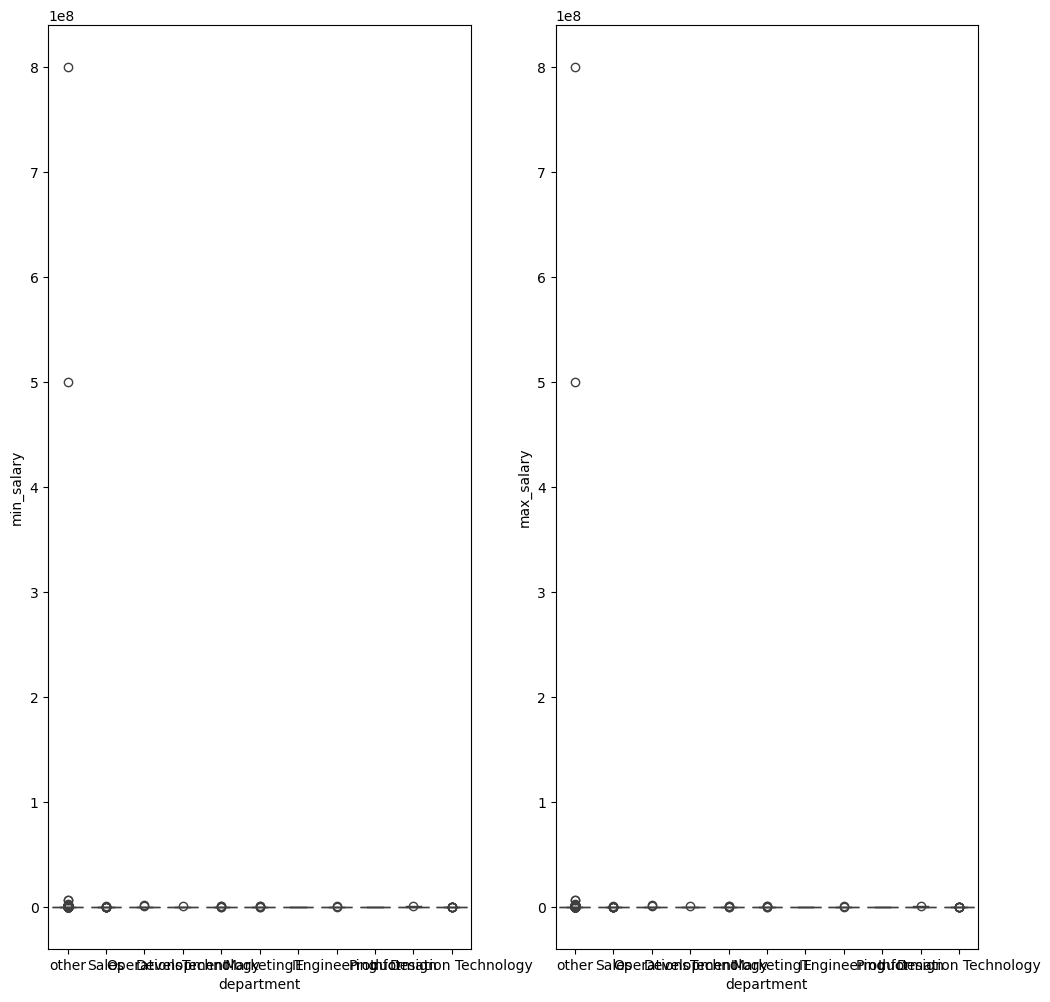

In [21]:
def get_pos(salary_range: str, post: int) -> int:
    try:
        return int(np.array(str(salary_range).split('-')[0]))
    except:
        return None


new_df = df[['department', 'salary_range']]
new_df = new_df.dropna()

new_df['min_salary'] = df.salary_range.apply(lambda x: get_pos(x, 0))
new_df['max_salary'] = df.salary_range.apply(lambda x: get_pos(x, 1))

fig, axes = plt.subplots(1,2, figsize=(12,12))

sns.boxplot(x='department', y='min_salary', data=new_df, ax=axes[0])
sns.boxplot(x='department', y='max_salary', data=new_df, ax=axes[1])

/tmp/ipykernel_233109/267335855.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(g.get_xticklabels(), rotation=90)
/tmp/ipykernel_233109/267335855.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(g.get_xticklabels(), rotation=90)


[Text(0, 0, 'other'),
 Text(1, 0, 'Operations'),
 Text(2, 0, 'Development'),
 Text(3, 0, 'Technology'),
 Text(4, 0, 'Marketing'),
 Text(5, 0, 'IT'),
 Text(6, 0, 'Sales'),
 Text(7, 0, 'Product'),
 Text(8, 0, 'Engineering'),
 Text(9, 0, 'Design'),
 Text(10, 0, 'Information Technology')]

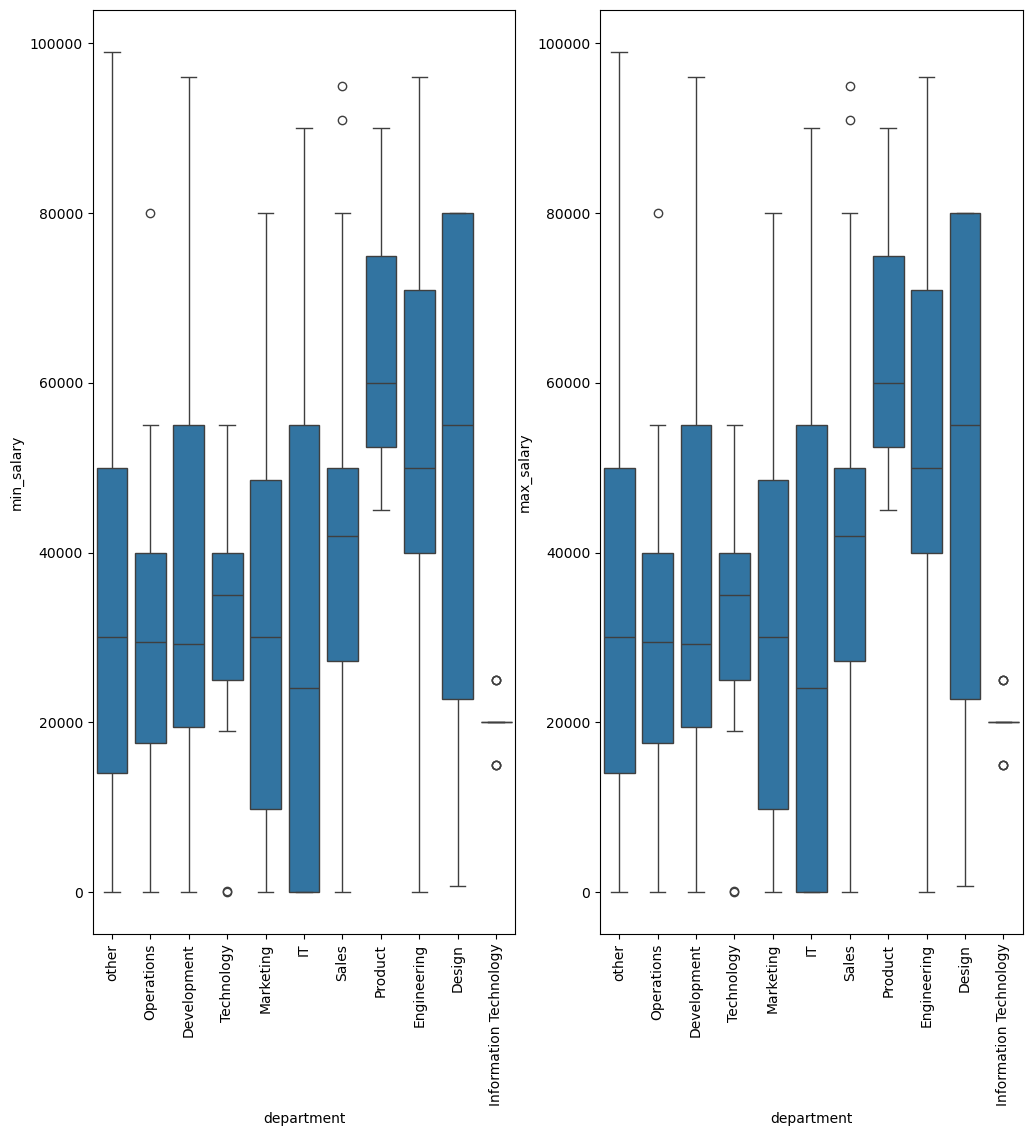

In [22]:

new_df = new_df[new_df['min_salary'] < 1e5]
new_df = new_df[new_df['max_salary'] < 1e5]

fig, axes = plt.subplots(1,2, figsize=(12,12))

g = sns.boxplot(x='department', y='min_salary', data=new_df, ax=axes[0])
g.set_xticklabels(g.get_xticklabels(), rotation=90)
g = sns.boxplot(x='department', y='max_salary', data=new_df, ax=axes[1])
g.set_xticklabels(g.get_xticklabels(), rotation=90)

# Traning

In [23]:
X = df.drop('fraudulent', axis=1)
y = pd.DataFrame(df['fraudulent'])

num_cols = list(X.select_dtypes('number'))
ordinal_cols = list(X.select_dtypes('object').nunique()[X.select_dtypes('object').nunique()>10].keys())
onehot_cols = list(X.select_dtypes('object').nunique()[X.select_dtypes('object').nunique()<=10].keys())

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=0)

In [24]:
num_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),
    ('scale', StandardScaler())
])

ordinal_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')), 
    ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

onehot_pipleline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessing = ColumnTransformer(transformers=[
    ('num_pipeline', num_pipeline, num_cols),
    ('ordinal_pipeline', ordinal_pipeline, ordinal_cols),
    ('onehot_pipeline', onehot_pipleline, onehot_cols)
])

model = XGBClassifier()

pipeline = Pipeline(steps=[
    ('transformer', preprocessing),
    ('model', model)
])

pipeline.fit(X_train, y_train)
preds = pipeline.predict(X_valid)

print(f'accuracy: {accuracy_score(y_valid, preds)}')

accuracy: 0.9830350484712901


In [25]:
pipeline

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('num_pipeline',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer()),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['job_id', 'telecommuting',
                                                   'has_company_logo',
                                                   'has_questions']),
                                                 ('ordinal_pipeline',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinal',
                                                                   OrdinalEncoder(handle_unknown='use_enc...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [26]:
with open('pipeline.pkl', 'wb') as file:
    pickle.dump(pipeline, file)


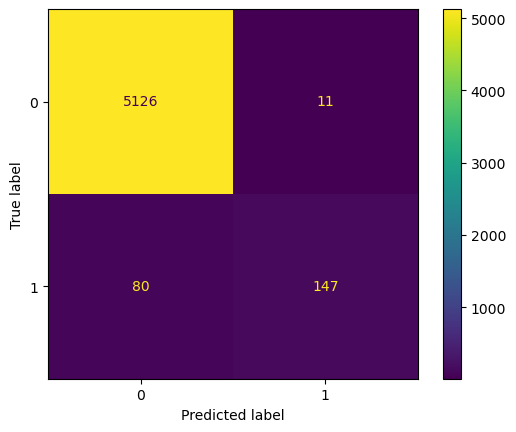

In [27]:
cm = confusion_matrix(y_valid, preds)
ConfusionMatrixDisplay(cm).plot()

# Optuna

In [29]:
def objective(trial):
    n_estimator = trial.suggest_int('n_estimators', 20, 400)
    booster = trial.suggest_categorical('booster', ['gbtree', 'gblinear', 'dart'])
    clf = XGBClassifier(n_estimator=n_estimator, booster=booster)
    pipeline = Pipeline(steps=[
        ('transformer', preprocessing),
        ('model', clf)
    ])
    pipeline.fit(X_train, y_train)
    return pipeline.score(X_valid, y_valid)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=3)

model_params_list = ['n_estimators', 'booster']
model_params = dict()

for key, value in study.best_trial.params.items():
    if key in model_params_list:
        model_params[key] = value

clf = XGBClassifier(**model_params)
pipeline = Pipeline(steps=[
    ('transformer', preprocessing),
    ('model', clf)
])
pipeline.fit(X_train, y_train)



[I 2024-10-11 14:02:08,760] A new study created in memory with name: no-name-5dd61ccf-97db-411a-b882-3c567c7567e0
/home/uz/anaconda3/envs/gcash/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:02:09] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1727634894600/work/src/learner.cc:740: 
Parameters: { "n_estimator" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-10-11 14:02:15,956] Trial 0 finished with value: 0.9830350484712901 and parameters: {'n_estimators': 231, 'booster': 'dart'}. Best is trial 0 with value: 0.9830350484712901.
/home/uz/anaconda3/envs/gcash/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:02:16] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1727634894600/work/src/learner.cc:740: 
Parameters: { "n_estimator" } are not used.

  warnings.warn(smsg, UserWarning)
[I 2024-10-11 14:02:16,502] Trial 1 finished with value: 0.9830350484712901 and parameters: {'n_estimators': 317, 'booster':

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('num_pipeline',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer()),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['job_id', 'telecommuting',
                                                   'has_company_logo',
                                                   'has_questions']),
                                                 ('ordinal_pipeline',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinal',
                                                                   OrdinalEncoder(handle_unknown='use_enc...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=231, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [30]:
import pickle
with open('pipeline.pkl', 'wb') as file:
    pickle.dump(pipeline, file)

In [31]:
from typing import Optional
from pydantic import BaseModel, Field, ValidationError

class Job(BaseModel):
    job_id: int = Field(..., description="Unique identifier for the job posting")
    title: object = Field(..., description="Title of the job")
    location: object = Field(..., description="Location of the job")
    department: Optional[object] = Field(None, description="Department of the job")
    salary_range: Optional[object] = Field(None, description="Salary range for the position")
    company_profile: Optional[object] = Field(None, description="Profile of the company")
    description: Optional[object] = Field(None, description="Job description")
    requirements: Optional[object] = Field(None, description="Job requirements")
    benefits: Optional[object] = Field(None, description="Benefits offered")
    telecommuting: int = Field(..., description="Telecommuting option (1 for yes, 0 for no)")
    has_company_logo: int = Field(..., description="Indicates if the company has a logo (1 for yes, 0 for no)")
    has_questions: int = Field(..., description="Indicates if there are questions for applicants (1 for yes, 0 for no)")
    employment_type: Optional[object] = Field(None, description="Type of employment (e.g., full-time, part-time)")
    required_experience: Optional[object] = Field(None, description="Required experience for the job")
    required_education: Optional[object] = Field(None, description="Required education level")
    industry: Optional[object] = Field(None, description="Industry of the job")
    function: Optional[object] = Field(None, description="Function or role of the job")

with open('pipeline.pkl', 'rb') as file:
    loaded_pipeline = pickle.load(file)

job = Job(**sample_row)
inputs = pd.DataFrame([job.model_dump()])
pred = loaded_pipeline.predict(inputs)[0]
pred

0

In [32]:
from flask import Flask, request, jsonify

app = Flask(__name__)

@app.route('/predict', methods=['POST'])
def predict():
    try:
        job = Job(**request.json)
        inputs = pd.DataFrame([job.model_dump()])
        pred = loaded_pipeline.predict(inputs)[0]
        response = {
            'perdiction': int(pred)
        }
        return jsonify(response), 200
    except ValidationError as e: 
        return jsonify(e.errors()), 400

if __name__=='__main__':
    app.run()

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [11/Oct/2024 14:03:02] "POST /predict HTTP/1.1" 200 -
